In [1]:
# This block allows us to import from the benchmark folder,
# as if it was a package installed using pip
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from torchvision import models

from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

from attrbench import models, attribution

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='../data/CIFAR10', train=True,
                                        download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../data/CIFAR10', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [4]:
model = models.Resnet(version="resnet18", output_logits=True, num_classes=10, params_loc="../data/models/CIFAR10/resnet18.pt")
model.eval()
pass

In [5]:
def imshow(img, transpose=True):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.cpu().detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

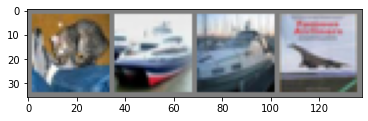

Ground Truth:   cat,  ship,  ship, plane
Predicted:   cat,  ship,  ship, plane


In [6]:
dataiter = iter(testloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print(f"Ground Truth: {', '.join('%5s' % classes[labels[j]] for j in range(4))}")
outputs = model(images)
_, predicted = torch.max(outputs, 1)
print(f"Predicted: {', '.join('%5s' % classes[predicted[j]] for j in range(4))}")

In [7]:
ind = 3
inp = images[ind].unsqueeze(0)
inp.requires_grad = True

In [8]:
kwargs = {
    "normalize": False,
    "aggregation_fn": None
}

attribution_methods = {
    "GuidedGradCAM": attribution.GuidedGradCAM(model, model.get_last_conv_layer(), **kwargs),
    "Gradient": attribution.Gradient(model, **kwargs),
    "InputXGradient": attribution.InputXGradient(model, **kwargs),
    "IntegratedGradients": attribution.IntegratedGradients(model, **kwargs),
    "GuidedBackprop": attribution.GuidedBackprop(model, **kwargs),
    "Deconvolution": attribution.Deconvolution(model, **kwargs),
}

In [9]:
attribution_results = {}
for m_name in attribution_methods:
    model.zero_grad()
    attribution_results[m_name] = attribution_methods[m_name](inp, labels[ind])

/home/arne/Documents/PhD/projects/benchmark/venv/lib/python3.7/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:56: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  "Setting backward hooks on ReLU activations."


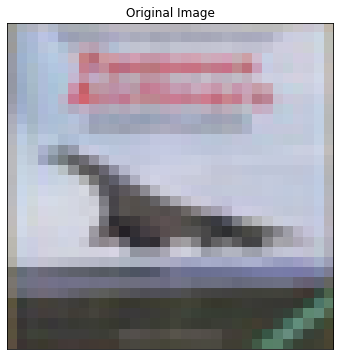

In [10]:
original_image = np.transpose((images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))
_ = viz.visualize_image_attr(None, original_image, method="original_image", title="Original Image")

(32, 32, 3)


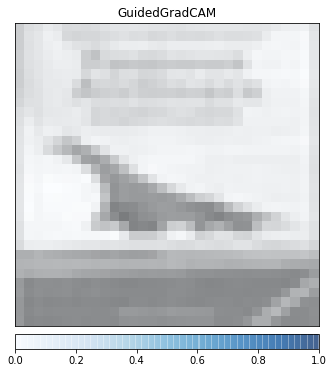

(32, 32, 3)


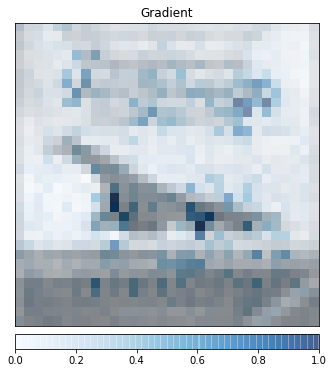

(32, 32, 3)


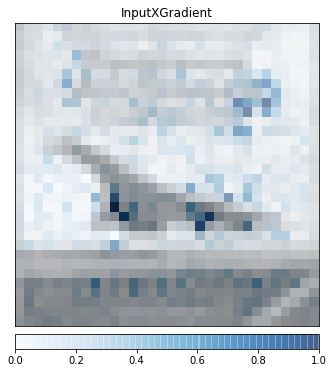

(32, 32, 3)


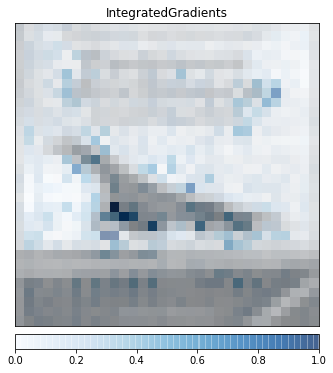

(32, 32, 3)


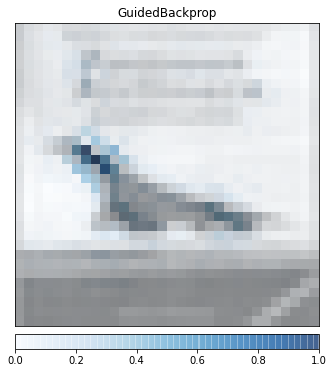

(32, 32, 3)


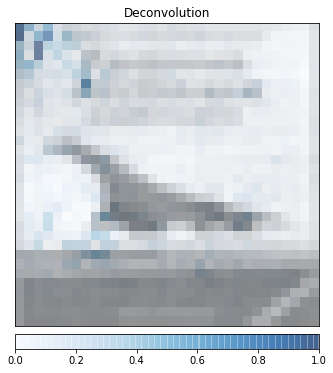

In [16]:
for m_name in attribution_results:
    attrs = attribution_results[m_name].squeeze(0).cpu().detach().numpy()
    attrs = np.transpose(attrs, (1, 2, 0))
    print(attrs.shape)
    _ = viz.visualize_image_attr(attrs, original_image, method="blended_heat_map", sign="absolute_value", show_colorbar=True, title=m_name)